# Modelagem da Planta em Espaço de Estados

<img src="Untitled.jpg" alt="Solução em Espaço de Estados" width="75%"/>

$$
\bold{x} =  \begin{bmatrix}
            i_{RC} \\
            v_c
            \end{bmatrix}
\space ; \space
\bold{\dot{x}} =    \begin{bmatrix}
                    \dot{i_{RC}} \\
                    \dot{v_c}
                    \end{bmatrix}
$$

$$
\bold{A} =  \begin{bmatrix}
            -\dfrac{1}{C_2}(\dfrac{1}{R_1} + \dfrac{1}{R_2}) & \dfrac{1}{R_1R_2C_2} \\
            \dfrac{1}{C_1}          & 0
            \end{bmatrix}
\space ; \space
\bold{B} =  \begin{bmatrix}
            \dfrac{1}{R_1R_2C_2} \\
            0
            \end{bmatrix}
$$

$$
\bold{C} =  \begin{bmatrix}
            0 & 1
            \end{bmatrix}
\space ; \space
D =  0
$$


In [41]:
import numpy as np
import pandas as pd
import control as ct
import scipy.signal as sig
import matplotlib.pyplot as plt

from numpy import linalg

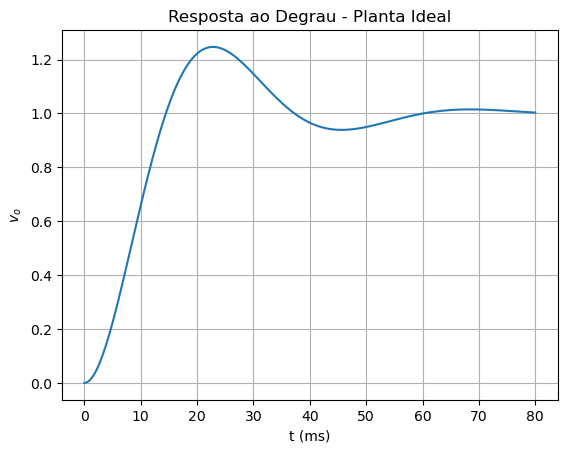

In [62]:
x0 = [0, 0]

t0   = 0
tf   = 80e-3
t    = np.linspace(t0, tf, 500)

NT = 18             # Emanuel(7) + Staub(5) + Araldi(6)
NP = 7              # Emanuel(7)
R1 = NT*2e3         # Resistência de Entrada
R2 = 18e3           # Resistência do Circuito RC
C1 = 100e-9         # Capacitância do Circuito RC
C2 = 680e-9         # Capacitância do Ampop

A  = [[0            , 1/C1],
      [-1/(R1*R2*C2) , -((1/(R1*C2))+(1/(R2*C2)))]]

B  = [[0],
      [1/(R1*R2*C2)]]

C  = [[1, 0]]

D  = 0

sys  = sig.StateSpace(A, B, C, D)
t, y = sig.step(sys, T=t)
tms  = t*1e3

plt.plot(tms, y)
plt.title("Resposta ao Degrau - Planta Ideal")
plt.xlabel("t (ms)")
plt.ylabel("$v_o$")
plt.grid()
plt.show()

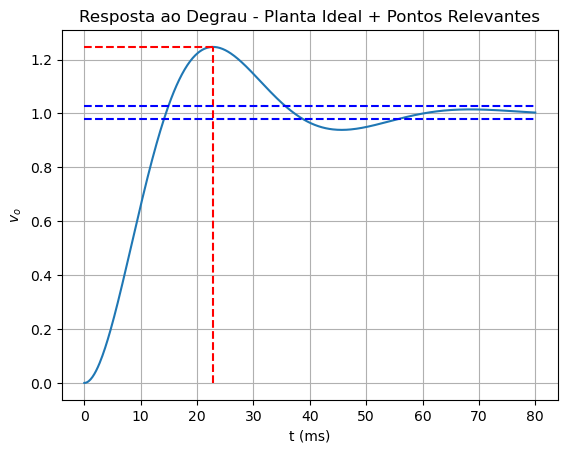

In [63]:
yM = np.max(y)
Mp = (yM-y[-1])/y[-1]
Tp = t[y==yM][0]
Δs = yM*2e-2 # Variação de 2% em função de steady state

plt.plot(tms, y)
## Pico
plt.plot(tms[t<=Tp], np.ones(len(t[t<=Tp]))*yM, 'r--')
plt.plot([Tp*1e3, Tp*1e3], [0, yM], 'r--')
## Acomodação de 2%
plt.plot(tms, np.ones(len(tms))*y[-1]*(1+Δs), 'b--') # Faixa de 2% (superior)
plt.plot(tms, np.ones(len(tms))*y[-1]*(1-Δs), 'b--') # Faixa de 2% (inferior)

plt.title("Resposta ao Degrau - Planta Ideal + Pontos Relevantes")
plt.xlabel("t (ms)")
plt.ylabel("$v_o$")
plt.grid()
plt.show()

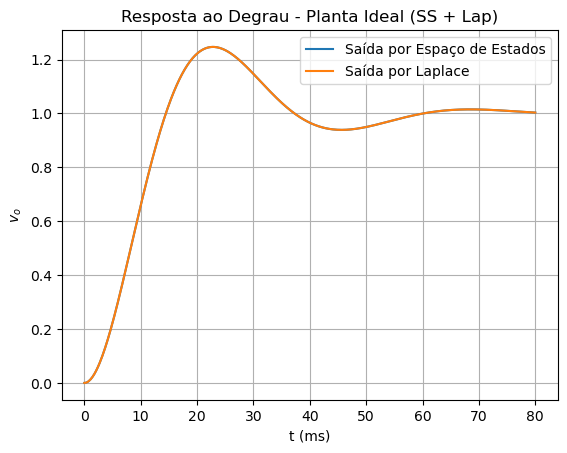

In [64]:
s  = ct.tf('s')
z  = (C1*R2+C1*R1)/(2*C1*C2*R1*np.sqrt(1/(C1*C2*R1*R2))*R2)
w2 = 1/(C1*C2*R1*R2)
w  = np.sqrt(w2)

G = w2/(s**2 + s*2*z*w + w2)
t_s, y_s = ct.step_response(G, T=t)
tms_s  = 1e3*t

plt.plot(tms, y)
plt.plot(tms_s, y_s)
plt.legend(["Saída por Espaço de Estados", "Saída por Laplace"])
plt.title("Resposta ao Degrau - Planta Ideal (SS + Lap)")
plt.xlabel("t (ms)")
plt.ylabel("$v_o$")
plt.grid()
plt.show()

Utilizando agora os valores reais da planta

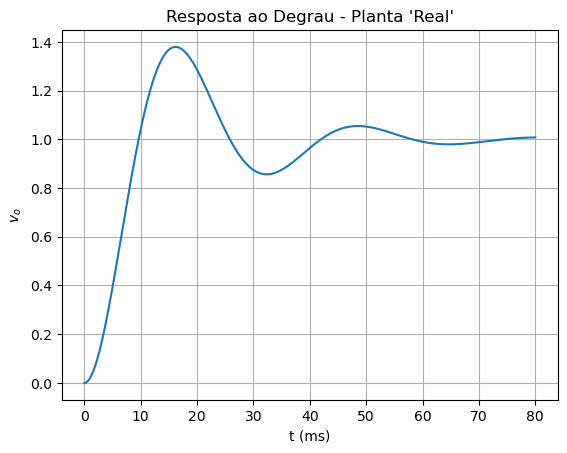

In [65]:
R1 = 35.8e3         # Resistência de Entrada
R2 = 17.95e3        # Resistência do Circuito RC
C1 = 54e-9          # Capacitância do Circuito RC
C2 = 697.7e-9       # Capacitância do Ampop

A  = [[0            , 1/C1],
      [-1/(R1*R2*C2) , -((1/(R1*C2))+(1/(R2*C2)))]]

B  = [[0],
      [1/(R1*R2*C2)]]

sys  = sig.StateSpace(A, B, C, D)
t, y = sig.step(sys, T=t)
tms  = t*1e3

plt.plot(tms, y)
plt.title("Resposta ao Degrau - Planta 'Real'")
plt.xlabel("t (ms)")
plt.ylabel("$v_o$")
plt.grid()
plt.show()

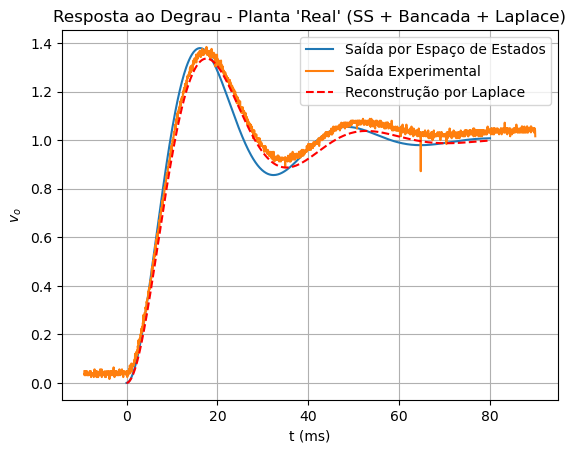

In [66]:
# Valores da planta real, obtidos experimentalmente
df = pd.read_csv("Input Files/Sinal_Sem_Controle.CSV", header=None)
tr = np.array(df[0])
Vo = np.array(df[1]) # Saída da Planta não Controlada

# Reconstrução por Laplace
Mp = 168e-3/500e-3
Tp = 17.60e-3
ζ   = -np.log(Mp)/np.sqrt(np.pi**2 + np.log(Mp)**2)
ω   = np.pi/(Tp*np.sqrt(1-ζ**2))
ω2  = ω**2
G = ω2/(s**2 + s*2*ζ*ω + ω2)
t_l, y_l = ct.step_response(G, T=t)
tms_l  = 1e3*t

plt.plot(tms, y)
plt.plot(1e3*tr, 2*(Vo - 1)) # Corrige Offset
plt.plot(tms_l, y_l, 'r--')
plt.legend(["Saída por Espaço de Estados", "Saída Experimental", "Reconstrução por Laplace"])
plt.title("Resposta ao Degrau - Planta 'Real' (SS + Bancada + Laplace)")
plt.xlabel("t (ms)")
plt.ylabel("$v_o$")
plt.grid()
plt.show()

In [67]:
fs  = 10e-2     # Fator de segurança

Mpc = NP*2e-2 * (1 - fs)
Tpc = NT*1e-3 * (1 - fs)

ζ  = -np.log(Mpc)/np.sqrt(np.pi**2 + np.log(Mpc)**2)
ω  = 3/(ζ*Tpc)
ωd = ω*np.sqrt(1-ζ**2)

j  = complex(0, 1)

u1 = -ζ*ω + j*ωd    # Polos Complexos Conjugados Desejados
u2 = -ζ*ω - j*ωd    # Polos Complexos Conjugados Desejados
# Recebendo Matriz de Ganhos
K  = ct.acker(A, B, [u1, u2])
print("K : ", K)
print("p : ", u1)
print("p*: ", u2)

K :  [[1.73996858e+00 1.12305184e+05]]
p :  (-185.18518518518513+280.8515065588941j)
p*:  (-185.18518518518513-280.8515065588941j)


In [68]:
# Verificando Polos

eq_car = np.poly(A-B*K)
print(np.roots(eq_car))

[-185.18518519+280.85150656j -185.18518519-280.85150656j]


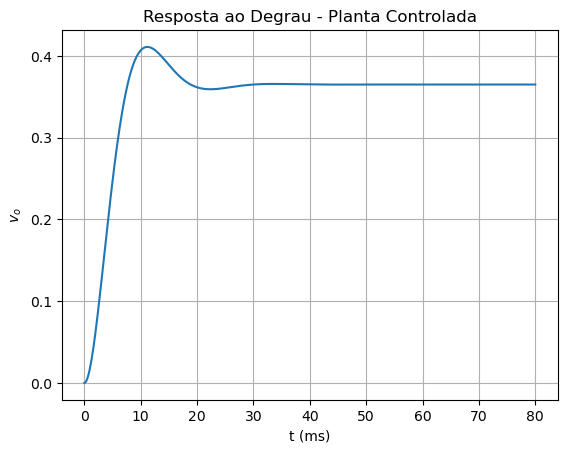

In [69]:
# Simulando Sistema Controlado
sys  = sig.StateSpace(A-B*K, B, C, D)
t, y = sig.step(sys, T=t)
tms  = t*1e3

plt.plot(tms, y)
plt.title("Resposta ao Degrau - Planta Controlada")
plt.xlabel("t (ms)")
plt.ylabel("$v_o$")
plt.grid()
plt.show()

In [70]:
# Eliminando Erro de Regime Permanente

A = np.array(A)
B = np.array(B)
C = np.array(C)

A_chapeu  = np.block([[A   , np.zeros([2,1])],
               [-C  , 0]])
B_chapeu  = np.block([[B],
               [0]])

K_chapeu  = ct.acker(A_chapeu, B_chapeu, [u1, u2, -1000])
K  = K_chapeu[0, :2]
Ki = -K_chapeu[0, 2]
print("---")
print("K_chapeu: ", K_chapeu)
print("---")
print("K: ", K)
print("---")
print("Ki: ", Ki)
print("---")
print("A_chapeu: ", A_chapeu)
print("---")
print("B_chapeu: ", B_chapeu)
print("---")

---
K_chapeu:  [[ 1.07069485e+01  5.60654181e+05 -2.73996858e+03]]
---
K:  [1.07069485e+01 5.60654181e+05]
---
Ki:  2739.9685771236113
---
A_chapeu:  [[ 0.00000000e+00  1.85185185e+07  0.00000000e+00]
 [-2.23040535e-03 -1.19884287e+02  0.00000000e+00]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00]]
---
B_chapeu:  [[0.        ]
 [0.00223041]
 [0.        ]]
---


In [71]:
autovalores, autovetores = linalg.eig(A_chapeu-B_chapeu*K_chapeu)
autovalores

array([-1000.          +0.j        ,  -185.18518519+280.85150656j,
        -185.18518519-280.85150656j])

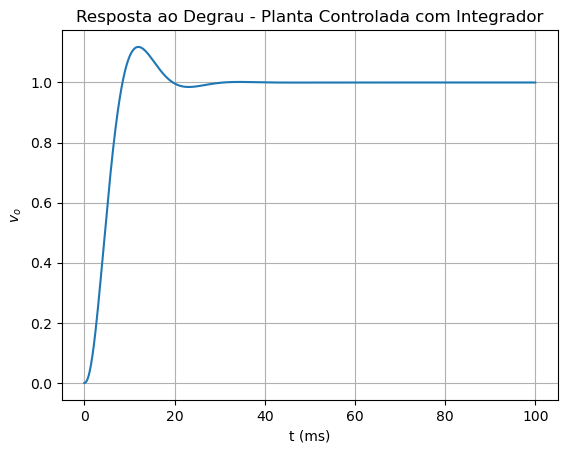

In [72]:
# Simulando Sistema Controlado com integrador
AA = np.block([[A-B*K, B*Ki],
               [-C   , 0]])

BB = np.block([[B],
               [1]])

CC = np.block([C, 0])

t    = np.linspace(0, 100e-3, 1000)
sys  = sig.StateSpace(AA, BB, CC, D)
t, y = sig.step(sys, T=t)
tms  = t*1e3

plt.plot(tms, y)
plt.title("Resposta ao Degrau - Planta Controlada com Integrador")
plt.xlabel("t (ms)")
plt.ylabel("$v_o$")
plt.grid()
plt.show()

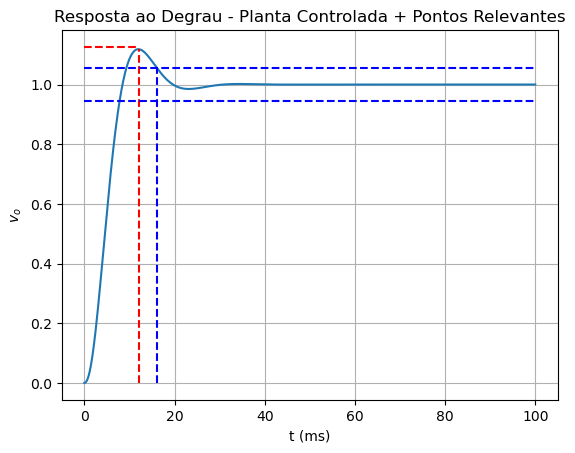

In [81]:
yM = np.max(y)
Mp = (yM-y[-1])/y[-1]
Tp = t[y==yM][0]
Δs = yM*5e-2 # Variação de 5% em função de steady state

plt.plot(tms, y)
## Pico
plt.plot(tms[t<=Tp], np.ones(len(t[t<=Tp]))*y[-1]*(1+Mpc), 'r--')
plt.plot([Tp*1e3, Tp*1e3], [0, yM], 'r--')
## Acomodação de 2%
plt.plot(tms, np.ones(len(tms))*y[-1]*(1+Δs), 'b--') # Faixa de 5% (superior)
plt.plot(tms, np.ones(len(tms))*y[-1]*(1-Δs), 'b--') # Faixa de 5% (inferior)
plt.plot([1e3*Tpc, 1e3*Tpc], [0, y[-1]*(1+Δs)], 'b--')

plt.title("Resposta ao Degrau - Planta Controlada + Pontos Relevantes")
plt.xlabel("t (ms)")
plt.ylabel("$v_o$")
plt.grid()
plt.show()

In [74]:
# Matriz de Ganhos do Observador
Ke = np.transpose(ct.acker(np.transpose(A),np.transpose(C),[u1, u2]))
Ke

array([[2.50486083e+02],
       [2.25925056e-03]])

In [89]:
AA_obs = np.block([[A, np.zeros([len(A),len(A)])],[Ke*C, A-Ke*C]])
BB_obs = np.block([[B],[B]])
CC_obs = np.eye(2*len(A))
DD_obs = np.zeros([2*len(A),1])

print("Matrizes do Observador")
print("A:", AA_obs)
print("B:", BB_obs)
print("C:", CC_obs)
print("D:", DD_obs)

obs = ct.ss(AA_obs,BB_obs,CC_obs,DD_obs)

t, X = ct.step_response(obs, t)
irc  = X[1, 0, :]
Vrc  = X[0, 0, :]

Matrizes do Observador
A: [[ 0.00000000e+00  1.85185185e+07  0.00000000e+00  0.00000000e+00]
 [-2.23040535e-03 -1.19884287e+02  0.00000000e+00  0.00000000e+00]
 [ 2.50486083e+02  0.00000000e+00 -2.50486083e+02  1.85185185e+07]
 [ 2.25925056e-03  0.00000000e+00 -4.48965590e-03 -1.19884287e+02]]
B: [[0.        ]
 [0.00223041]
 [0.        ]
 [0.00223041]]
C: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
D: [[0.]
 [0.]
 [0.]
 [0.]]


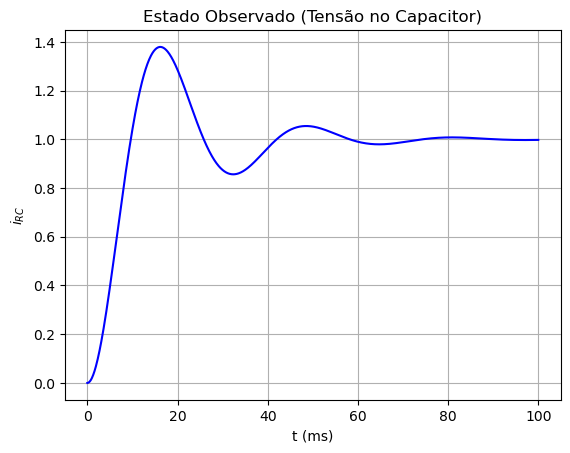

In [92]:
plt.figure()
plt.plot(t*1e3, Vrc, 'b')
plt.xlabel("t (ms)")
plt.ylabel("$i_{RC}$")
plt.title("Estado Observado (Tensão no Capacitor)")
plt.grid(True)
plt.show()

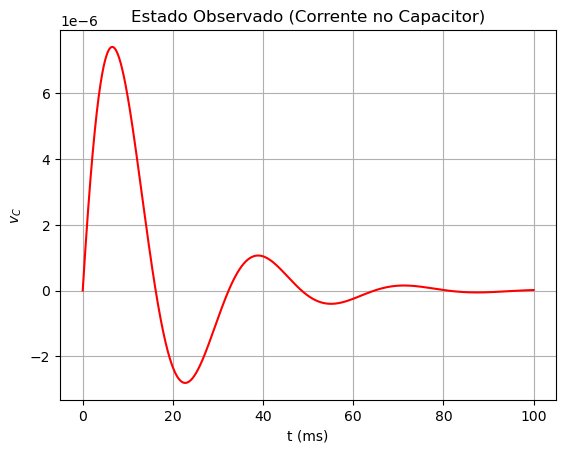

In [93]:
plt.figure()
plt.plot(t*1e3, irc, 'r')
plt.xlabel("t (ms)")
plt.ylabel("$v_{C}$")
plt.title("Estado Observado (Corrente no Capacitor)")
plt.grid(True)
plt.show()

In [78]:
from PyLTSpice import RawRead

plant_raw = RawRead("Input Files/Analogico_LF356.raw")
time_simul = plant_raw.get_trace("time").get_wave()
Vout_simul = plant_raw.get_trace("V(Vout)").get_wave()
Vc_simul = plant_raw.get_trace("V(C1)").get_wave()
irc_simul = -plant_raw.get_trace("I(R2)").get_wave()

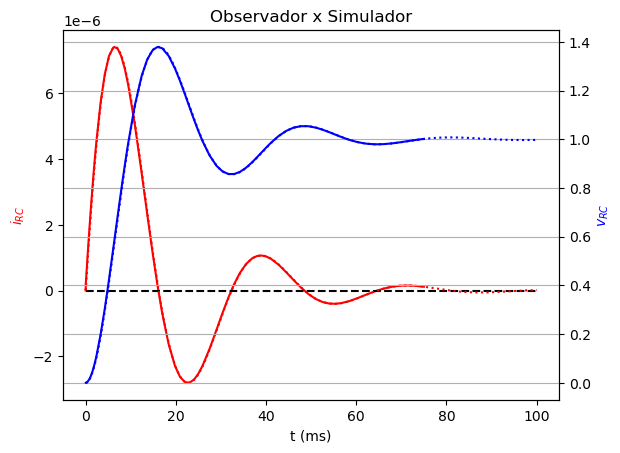

In [94]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("t (ms)")
ax1.set_ylabel("$i_{RC}$", color='r')
ax1.plot(time_simul*1e3, irc_simul, 'r')
ax1.plot([0, t[-1]*1e3], [0, 0], 'k--')
ax1.plot(t*1e3, irc, 'r:')

ax2 = ax1.twinx()
ax2.set_ylabel("$v_{RC}$", color='b')
ax2.plot(time_simul*1e3, Vc_simul, 'b')
ax2.plot(t*1e3, Vrc, 'b:')
plt.title("Observador x Simulador")
plt.grid(True)
plt.show()

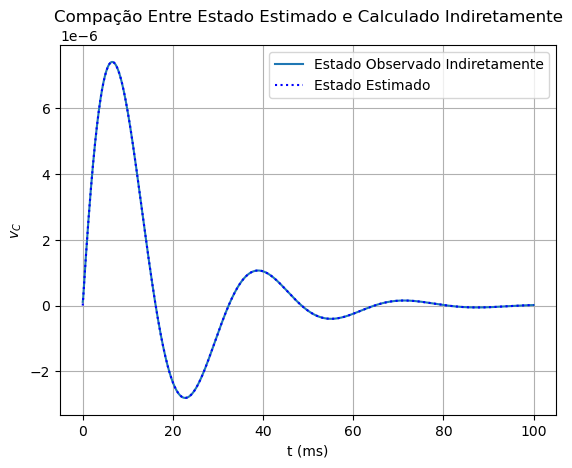

In [95]:
dirc = C1*np.gradient(Vrc, (t[1]-t[0]))

plt.plot(t*1e3, dirc)
plt.plot(t*1e3, irc, 'b:')
plt.xlabel("t (ms)")
plt.ylabel("$v_{C}$")
plt.title("Compação Entre Estado Estimado e Calculado Indiretamente")
plt.legend(["Estado Observado Indiretamente", "Estado Estimado"])
plt.grid(True)
plt.show()